In [1]:
%conda install -c conda-forge namaster

2 channel Terms of Service accepted
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.9.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/camb

  added / updated specs:
    - namaster


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.11.12 |       hbd8a1cb_0         149 KB  conda-forge
    openssl-3.6.0              |       h230baf5_0         2.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following packages will be UPDATED:

  ca-certificates                      2025.10.5-hbd8a1cb_0 --> 2025.11.12-hbd8a1cb_

In [ ]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pymaster as nmt
from GGL_model import cosmology, power_spectrum

Data import

In [3]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

hdudes = fits.open('data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits')

data_source = hdudes['nz_source'].data[:-1]
data_lens = hdudes['nz_lens'].data[:-1]

Create dictionary for the lens and source data with the bin number as key value. For the redshift callibration, we also get the mean redshift per bin.

In [4]:
#redshift bins Redmagic
z_lims = np.array([0.15,0.35,0.5,0.65,0.8,0.9])

bin_number_source = 4
zs = np.array(data_source['Z_MID'])
zs_bins = []
zs_means = []
nz_source_dict = {}
for i in range(bin_number_source):
    z = zs[(zs >= z_lims[i]) & (zs < z_lims[i+1])]
    zs_bins.append(np.array(z))
    zs_means.append(np.mean(z))
    nz_source_dict[i] = data_source['BIN' + str(i+1)]


bin_number_lens = 5
zl = np.array(data_lens['Z_MID'])
zl_bins = []
zl_means = []
nz_lens_dict = {}
for i in range(bin_number_lens):
    z = zl[(zl >= z_lims[i]) & (zl < z_lims[i+1])]
    zl_bins.append(np.array(z))
    zl_means.append(np.mean(z))
    nz_lens_dict[i] = data_lens['BIN' + str(i+1)]

Define bias parameters

In [5]:
#Biases REDMAGIC
galaxy_bias = np.array([1.7, 1.7, 1.7, 2.0, 2.0])  # lens galaxy bias for each lens bin
magnification_bias = np.array([1.3134, -0.5179, 0.3372, 2.2515, 1.9667])  # magnification bias for each lens bin
shear_calibration_bias = np.array([-0.0063,-0.0198,-0.0241,-0.0369])  # shear calibration bias for each source bin

#redshift shift for lens galaxsssies REDMAGIC
shift_params = np.array([0.006,0.001,0.004,-0.002,-0.007])
stretch_params = np.array([1,1,1,1,1.23])

#Intrinsic Alignment (IA)
IA_params = np.array([0.7,-1.36,-1.7,-2.5,1.0,0.62]) #a1,a2,alf1,alfa2,bTA,z0
C1_mean=5e-14 # h^2 Msun^-1 Mpc^3

Initialization, zmin=0.01 to avoid division by 0

In [6]:
c = cosmology()
zmin = 0.1
zmax = max(zs.max(), zl.max(),)
ps = power_spectrum(zmin=zmin, zmax=zmax,kmax=10)

kmin = 1.000e-04, kmax = 1.000e+01, chimin = 4.341e+02, chimax = 8.420e+03, zmin = 0.100, zmax = 5.990


In [7]:
# l bins are integers but close to the 
lmin = 8
lmax = 2048
n_bins = 32
nside = 1024

# Generate sqrt-spaced edges
sqrt_edges = np.linspace(np.sqrt(lmin), np.sqrt(lmax), n_bins + 1)
edges = sqrt_edges**2
edges = np.round(edges).astype(int)
edges[-1] = lmax + 1

# Create NaMaster binning object
b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
ell_arr = b.get_effective_ells()

In [8]:
nside = 256
npix = hp.nside2npix(nside)
pixwin = hp.pixwin(nside)
lmax = 3*nside-1
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=10)
ell_arr = b.get_effective_ells()

In [9]:
highdens = fits.open('data/y3a2_gold2.2.1_redmagic_highdens.fits')[1].data # Galaxy positions for bins 1-3
highlum = fits.open('data/y3a2_gold2.2.1_redmagic_highlum_highz.fits')[1].data # Galaxy positions for bins 4,5

random_highdens = fits.open('data/y3a2_gold2.2.1_redmagic_highdens_randoms.fits')[1].data # Random positions for bins 1-3
random_highlum = fits.open('data/y3a2_gold2.2.1_redmagic_highlum_highz_randoms.fits')[1].data # Random positions for bins 4,5

hdu_sel = fits.open('data/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits') # Joint (Redmagic+Maglim) sky mask
pixel_index = hdu_sel[1].data['HPIX']        # pixel indices at NSIDE=4096
mask_value  = hdu_sel[1].data['FRACGOOD']    # fractional coverage

# Create empty HEALPix map
nside_in = 4096
npix_in = hp.nside2npix(nside_in)
mask_map = np.zeros(npix_in, dtype=np.float64)

# Fill map with values
mask_map[pixel_index] = mask_value

# Downgrade to your desired NSIDE for analysis
mask_sel = hp.ud_grade(mask_map, nside)

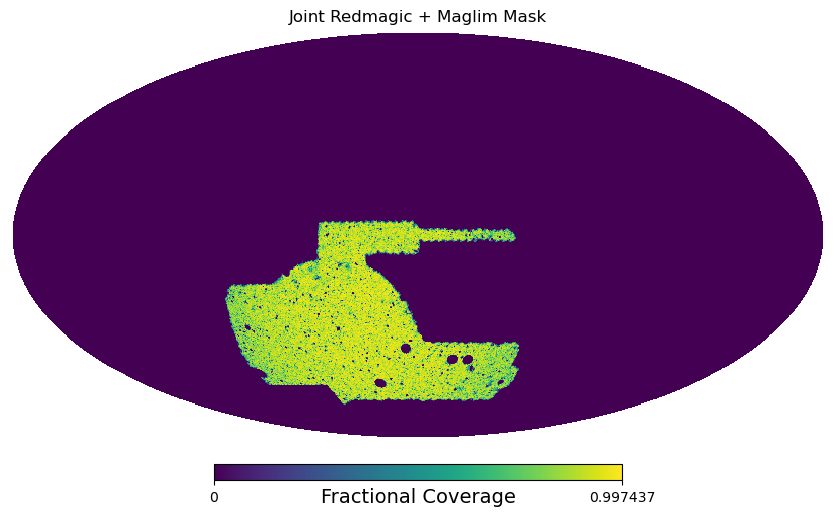

In [10]:
hp.mollview(mask_sel, title='Joint Redmagic + Maglim Mask', unit='Fractional Coverage')
plt.show()

In [11]:
#shear response for REDMAGIC
R_shear = np.array([0.7636,0.7182,0.6887,0.6154])
R_selection = np.array([0.0046,0.0083,0.0126,0.0145])
R = R_shear+R_selection

$$w_p \frac{\Sigma_pN_p}{\Sigma_p w_p}$$


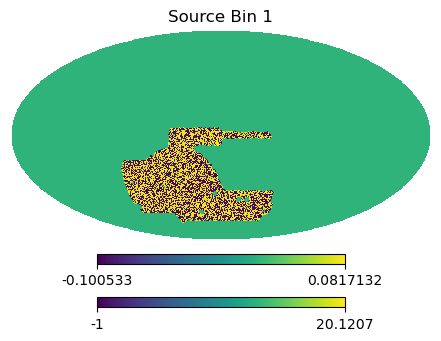

In [47]:
shear_fields = {}
density_fields = {}


for i in range(1, 2):
    if i<4:
        mask_bin = highdens['BIN_NUMBER'] == i
        lens_galaxies_bin = highdens[mask_bin]
        mask_bin = random_highdens['BIN_NUMBER'] == i
        random_galaxies = random_highdens[mask_bin]
    else:
        mask_bin = highlum['BIN_NUMBER'] == i
        lens_galaxies_bin = highlum[mask_bin]
        mask_bin = random_highlum['BIN_NUMBER'] == i
        random_galaxies = random_highlum[mask_bin]

    ra = lens_galaxies_bin['RA']
    dec = lens_galaxies_bin['DEC']
    ipix = hp.ang2pix(nside, ra, dec, lonlat=True)

    ra_ran = random_galaxies['RA']
    dec_ran = random_galaxies['DEC']
    ipix_ran = hp.ang2pix(nside, ra_ran, dec_ran, lonlat=True)

    w_data = lens_galaxies_bin['WEIGHT']
    w_ran = np.ones(len(ra_ran), dtype=float)

    n_data = np.bincount(ipix, weights=w_data, minlength=hp.nside2npix(nside))
    n_ran  = np.bincount(ipix_ran,  weights=w_ran, minlength=hp.nside2npix(nside))

    good = (n_ran > 0) & (mask_sel > 0)
    delta = np.zeros_like(mask_sel, dtype=float)
    delta[good] = n_data[good] / n_ran[good] / np.mean(n_data[good] / n_ran[good]) - 1.0
    delta[~good] = -1
    hp.mollview(delta, title=f'Lens Bin {i}', norm = 'hist', hold=True)


    density_fields[i] = nmt.NmtField(mask_sel, np.array([delta]), spin=0, lmax=lmax,lmax_mask=lmax)

    if i<5:
        mask_1024 = hp.read_map(f'data/DES_shear_maps/mask_shear_z{i}.fits')
        e1_1024 = hp.read_map(f'data/DES_shear_maps/shear_e1_z{i}.fits')
        e2_1024 = hp.read_map(f'data/DES_shear_maps/shear_e2_z{i}.fits')
        mask = hp.ud_grade(mask_1024, nside)
        e1 = hp.ud_grade(e1_1024, nside)
        e2 = hp.ud_grade(e2_1024, nside)

        e1 *= -1
        hp.mollview(e2, title=f'Source Bin {i}', norm = 'hist', hold=True)

        shear_fields[i] = nmt.NmtField(mask, np.array([e1, e2])/R[i-1], spin=2, lmax=lmax,lmax_mask=lmax)  

plt.show()


In [13]:
import os

outdir=f"cov_workspaces_nside{nside}"
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [14]:
def get_cl(w,f1, f2):
    cl = w.decouple_cell(nmt.compute_coupled_cell(f1, f2))
    return cl

pcls = np.zeros((5,4,2,len(ell_arr)))
for i in range(1, 6):
    for j in range(1, 5):
        print(f"working on bins {i} {j}")
        w = nmt.NmtWorkspace.from_fields(density_fields[i], shear_fields[j], b)
        w.write_to(os.path.join(outdir, f"w{i}{j}.fits"))

        cw = nmt.NmtCovarianceWorkspace.from_fields(
                density_fields[i], shear_fields[j], density_fields[i], shear_fields[j]
            )
        cw.write_to(os.path.join(outdir, f"cw{i}{j}.fits"))
        

        pcl = get_cl(w, density_fields[i], shear_fields[j])
        pcls[i-1, j-1, :, :] = pcl

working on bins 1 1
working on bins 1 2
working on bins 1 3
working on bins 1 4
working on bins 2 1
working on bins 2 2
working on bins 2 3
working on bins 2 4
working on bins 3 1
working on bins 3 2
working on bins 3 3
working on bins 3 4
working on bins 4 1
working on bins 4 2
working on bins 4 3
working on bins 4 4
working on bins 5 1
working on bins 5 2
working on bins 5 3
working on bins 5 4


In [15]:
# Flatten so each row is (i, j, spec, cl[ell])
rows = []

for i in range(5):
    for j in range(4):
        for s in range(2):
            row = [i, j, s] + pcls[i, j, s, :].tolist()
            rows.append(row)

rows_array = np.array(rows)

# Save to CSV
np.savetxt(f"pcls_ge_nside{nside}.csv", rows_array, delimiter=",", fmt="%.6e")

In [16]:
cls = np.zeros((5,4,len(ell_arr)))
for j in range(5):
    for i in range(4):
            nz_source = nz_source_dict[i]
            nz_lens = nz_lens_dict[j]   
            zl_mean = zl_means[j]         

            shift_lens = shift_params[j] if shift_params is not None else 0
            stretch_lens = stretch_params[j] if stretch_params is not None else 1
            shear = shear_calibration_bias[i] if shear_calibration_bias is not None else 0
            gb = galaxy_bias[j]
            mb = magnification_bias[i]
            cls[j,i,:] = ps.lensing_power(l_bins=ell_arr, galaxy_bias=gb, zl=zl, zs=zs, nz_lens=nz_lens, nz_source=nz_source, zl_mean=zl_mean, nz_lens_stretch=stretch_lens, nz_lens_shift=shift_lens,shear=shear)

rows = []
for i in range(5):
    for j in range(4):
            row = [i, j] + cls[i, j, :].tolist()
            rows.append(row)

rows_array = np.array(rows)

# Save to CSV
np.savetxt("cls_ge_linb.csv", rows_array, delimiter=",", fmt="%.6e")      

Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (earliest first)
Working on lensing power
Note: redshifts have been re-sorted (ea

In [17]:
hdufid = fits.open('data/sim_3x2_fiducial_nla.fits')
cls_fid = hdufid['galaxy_shear_cl'].data

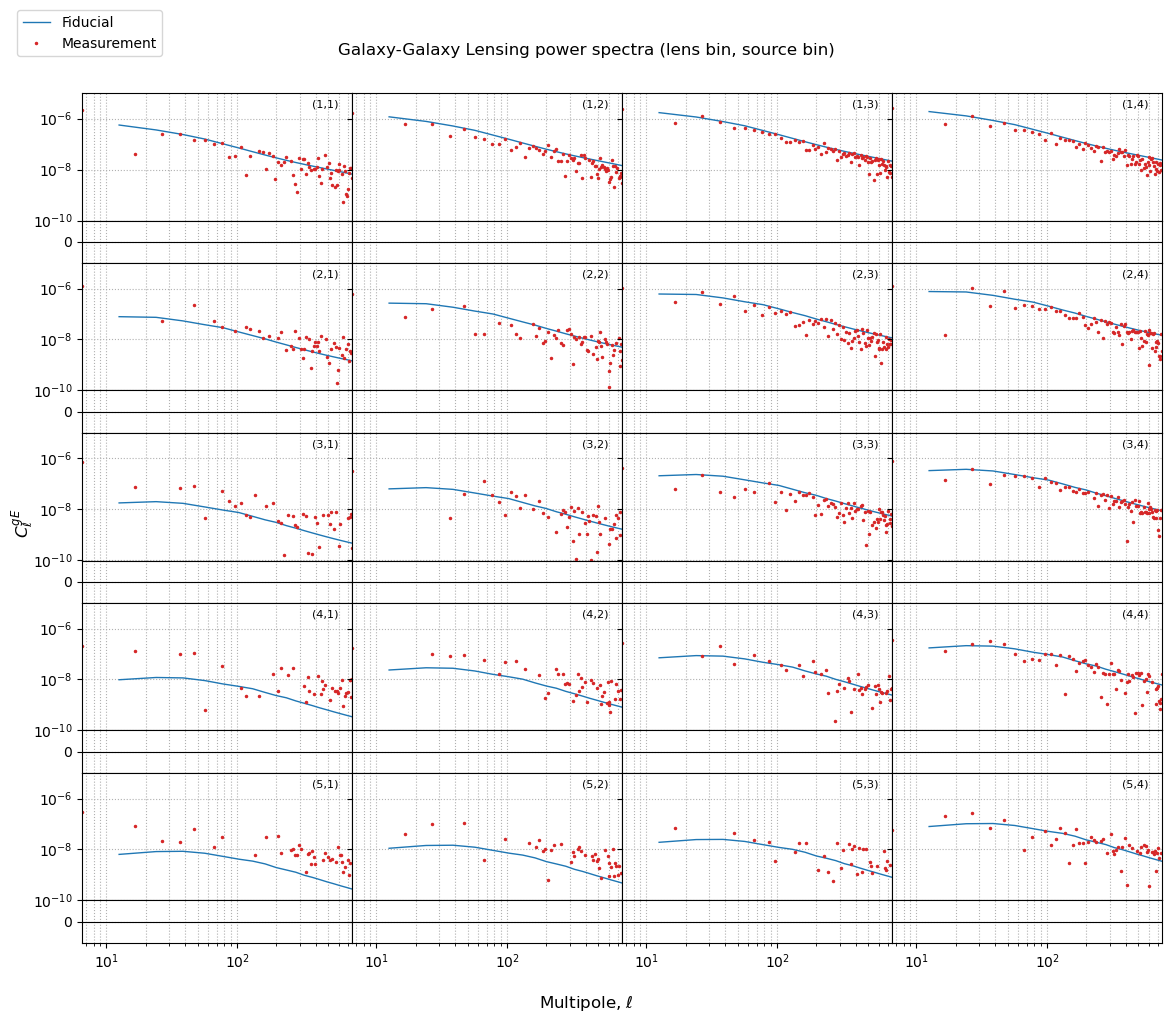

In [18]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter

# Grid sizes
n_lens, n_source = 5, 4

# --- Create figure and GridSpec with smaller height ratio for residuals ---
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Galaxy-Galaxy Lensing power spectra (lens bin, source bin)')

gs = GridSpec(n_lens * 2, n_source, figure=fig, 
              height_ratios=[3, 1]*n_lens,  # main:residual ratio 3:1
              hspace=0.0, wspace=0.0)       # no gaps

# --- Loop over bins ---
for i in range(n_lens):
    for j in range(n_source):
        # Main and residual axes stacked vertically, touching
        ax_main = fig.add_subplot(gs[2*i, j])
        ax_resid = fig.add_subplot(gs[2*i + 1, j], sharex=ax_main)

        # --- Select fiducial + theory data ---
        cl_fid = np.array([
            cls_fid['VALUE'][x] for x in range(len(cls_fid))
            if cls_fid['BIN1'][x] == i + 1 and cls_fid['BIN2'][x] == j + 1
        ])
        l_bins_fid = np.array([
            cls_fid['ANG'][x] for x in range(len(cls_fid))
            if cls_fid['BIN1'][x] == i + 1 and cls_fid['BIN2'][x] == j + 1
        ])

        # --- Main spectra ---
        ax_main.plot(l_bins_fid, cl_fid, color='C0', lw=1, label='Fiducial')
        #ax_main.plot(ell_arr, cls[i, j, :], color='C1', lw=1, label='Theory')
        ax_main.plot(ell_arr, pcls[i, j, 0, :], '.', color='C3', ms=3, label='Measurement')
        ax_main.text(0.95, 0.95, f"({i+1},{j+1})",
                     transform=ax_main.transAxes, ha="right", va="top", fontsize=8)

        ax_main.set_xscale('log')
        ax_main.set_yscale('log')
        ax_main.grid(True, which='both', ls=':')
        ax_main.label_outer()  # hides overlapping labels


        # --- Residuals ---
        #residual = pcls[i, j, 0, :] - cls[i, j, :]
        ax_resid.axhline(0, color='k', lw=0.8)
        #ax_resid.plot(ell_arr, residual, '.', color='C3', ms=3)
        ax_resid.set_xscale('log')
        ax_resid.set_ylim(-2e-8, 2e-8)
        ax_resid.grid(True, which='both', ls=':')

        # --- Only show 0 tick on residuals, no scientific notation ---
        ax_resid.yaxis.set_major_locator(FixedLocator([0]))
        ax_resid.yaxis.set_major_formatter(FixedFormatter(['0']))

        # --- Ticks & labels control ---
        if j > 0:
            ax_main.set_yticklabels([])
            ax_resid.set_yticklabels([])

        # Shared limits for main plots
        ax_main.set_xlim(min(ell_arr), max(ell_arr))
        ax_main.set_ylim(1e-10, 1e-5)

# --- Shared labels ---
fig.supxlabel(r"Multipole, $\ell$", fontsize=12)
fig.supylabel(r"$C_{\ell}^{gE}$", fontsize=12)

# --- Shared legend (only once) ---
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.02, 1.02), ncol=1)

# --- Tight layout ---
plt.subplots_adjust(wspace=0.0, hspace=0.0, top=0.93, bottom=0.08, left=0.08, right=0.98)
plt.show()
